In [3]:
!pip install mysql-connector-python requests pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 30.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.21.12 which is incompatible.


In [33]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import mysql.connector
from mysql.connector import Error
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [37]:
def create_db_connection(host_name, db_port, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            port=db_port,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

def execute_query(connection, query, data=None, commit=False):
    cursor = connection.cursor()
    try:
        if data:
            cursor.execute(query, data)
        else:
            cursor.execute(query)
        if commit:
            connection.commit()
    except Error as e:
        print(f"The error '{e}' occurred")

def execute_read_query(connection, query):
    cursor = connection.cursor(dictionary=True)
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=KRW&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])

connection = create_db_connection("svc.sel5.cloudtype.app", "31979", "root", "kim0523", "cryptocurrency")

for index, row in hist.iterrows():
    data = (
        pd.to_datetime(row['time'], unit='s'),
        row['high'],
        row['low'],
        row['open'],
        row['close'],
        row['volumefrom'],
        row['volumeto']
    )
    query = """
    INSERT INTO btc_price_history (time, high, low, open, close, volumefrom, volumeto)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE
    high=VALUES(high), low=VALUES(low), open=VALUES(open), close=VALUES(close), volumefrom=VALUES(volumefrom), volumeto=VALUES(volumeto);
    """
    execute_query(connection, query, data, commit=True)

btc_price_history = execute_read_query(connection, "SELECT * FROM btc_price_history")

btc_price_history_df = pd.DataFrame(btc_price_history)
btc_price_history_df.set_index('time', inplace=True)


MySQL Database connection successful
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:09' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:09' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:09' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:09' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:10' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:10' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:10' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:10' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:10' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 14:27:11' for key 'PRIMARY'' occurred
The error '1062 (23000): Duplicate entry '2023-11-21 

In [38]:
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [39]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [40]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2023-11-17,49445644.14,48569051.00,48870879.19,5680.08,2.783555e+11,49371347.90
2023-11-18,49474851.09,48868539.61,49371347.90,3032.52,1.489648e+11,49172942.23
2023-11-19,49983742.11,48978695.87,49172942.23,3331.47,1.641038e+11,49809260.21
2023-11-20,50288623.61,49322849.56,49809260.21,5849.43,2.914349e+11,50164112.51
2023-11-21,50351831.91,49931052.92,50164112.51,1662.74,8.339518e+10,49993189.04


In [41]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [42]:
train, test = train_test_split(hist, test_size=0.2)

In [45]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [KRW]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

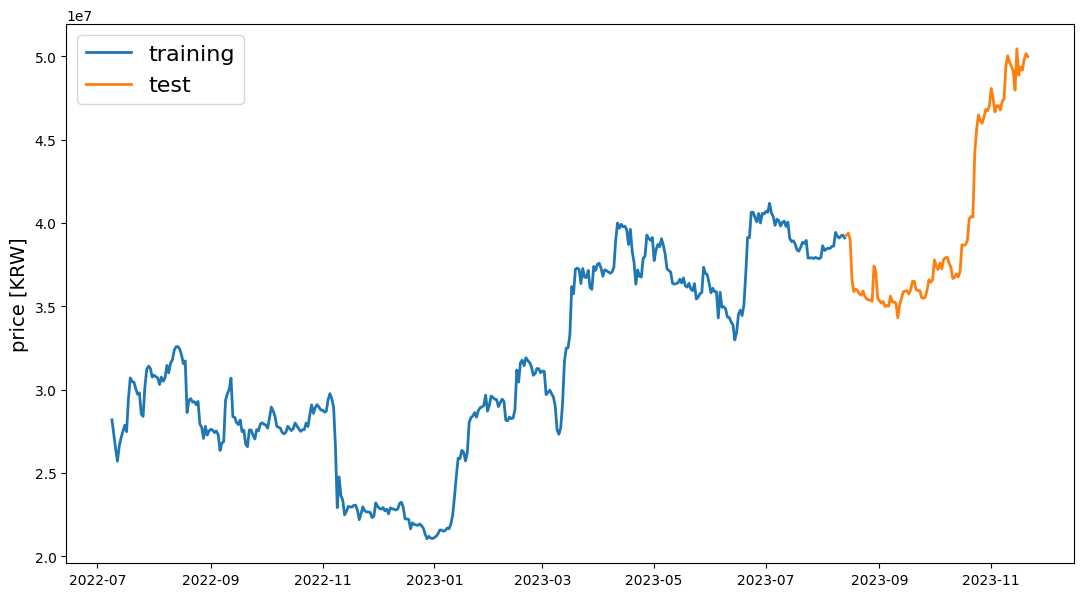

In [46]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [47]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [48]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [49]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [50]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [51]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [52]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [53]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 4s 70ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 2/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 8.8878e-04
Epoch 3/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 7.3896e-04
Epoch 5/20
13/13 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 7.1525e-04
Epoch 6/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 6.7721e-04
Epoch 7/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 7.8454e-04
Epoch 8/20
13/13 [==============================] - 0s 31ms/step - loss: 0.0012 - val_loss: 6.8580e-04
Epoch 9/20
13/13 [==============================] - 0s 36ms/step - loss: 0.0013 - val_loss: 5.6277e-04
Epoch 10/20
13/13 [==============================] - 0s 31ms/step - loss: 0.0011 

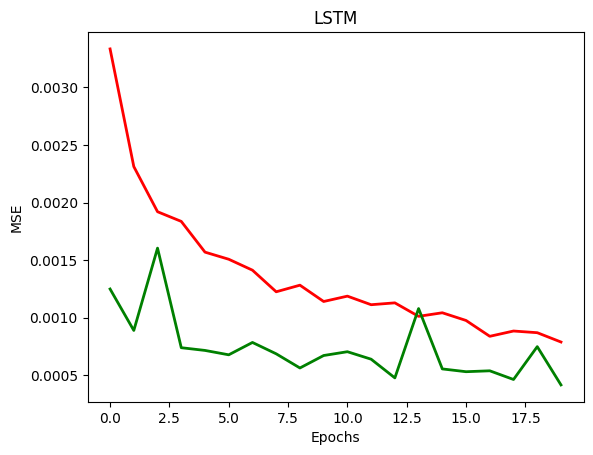

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [55]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 3s 10ms/step


0.013337384247546073

In [56]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0004156386941368538

In [57]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7936318602271832

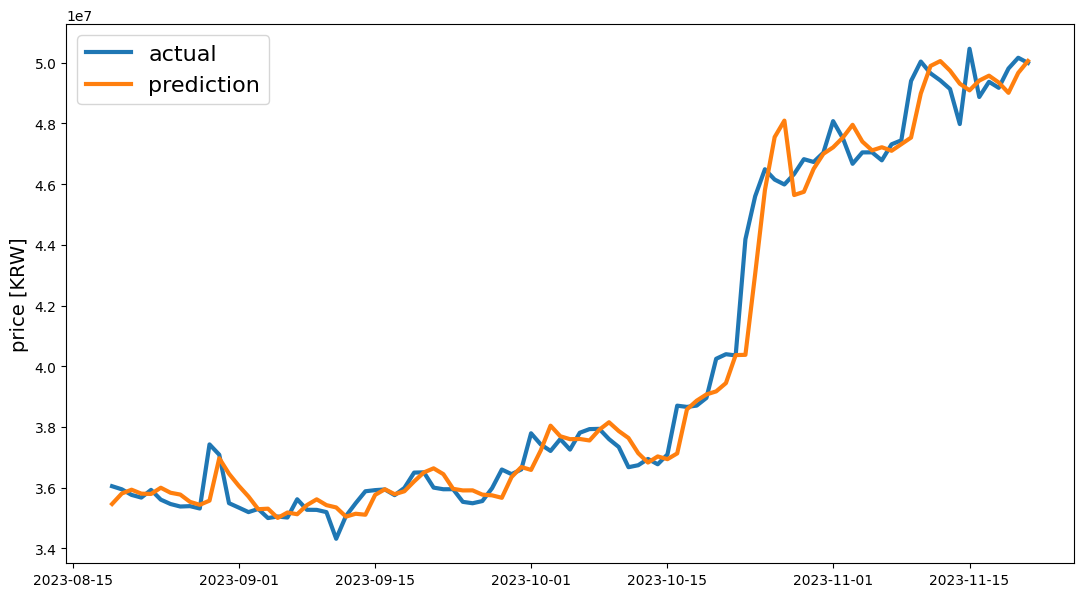

In [58]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)